#### Training Sample: train.csv with undersampling
#### Evaluation Sample: validation_under.csv
#### Method: OOB
#### Output: Best hyperparameters; Pr-curve; ROC AUC

# Training Part 

In [65]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import StratifiedKFold 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc,f1_score,make_scorer,classification_report, matthews_corrcoef, accuracy_score, average_precision_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from scipy import interp

In [66]:
def FiveFoldROC(estimator, X, y):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    cv = StratifiedKFold(n_splits=5)
    for train, test in cv.split(X, y):
    # Compute ROC curve and area the curve
        print(train)
        print(test)
        estimator.fit(X[train], y[train])
        y_score = estimator.predict_proba(X[test])[:,1]
        fpr, tpr, thresholds = roc_curve(y[test], y_score, pos_label=1)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
            label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [67]:
transactions = pd.read_csv('../Data/creditcard.csv')
sklearn.utils.shuffle(transactions)
X_train = transactions.drop(labels='Class', axis=1)
y_train = transactions.loc[:,'Class']

In [68]:
rus = RandomUnderSampler(sampling_strategy=0.8)
X_res, Y_res = rus.fit_resample(X_train, y_train)

In [118]:
test = 1

if test== 0:
    n_estimators = [75,150,800,1000,1200]
    min_samples_split = [2, 5]
    min_samples_leaf = [1, 5]
else:
    n_estimators = [350]
    min_samples_split = [2]
    min_samples_leaf = [1]

In [167]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators = 65,
                 min_samples_split=2,
                 min_samples_leaf=1)

[ 123  124  125  126  127  128  129  130  131  132  133  134  135  136
  137  138  139  140  141  142  143  144  145  146  147  148  149  150
  151  152  153  154  155  156  157  158  159  160  161  162  163  164
  165  166  167  168  169  170  171  172  173  174  175  176  177  178
  179  180  181  182  183  184  185  186  187  188  189  190  191  192
  193  194  195  196  197  198  199  200  201  202  203  204  205  206
  207  208  209  210  211  212  213  214  215  216  217  218  219  220
  221  222  223  224  225  226  227  228  229  230  231  232  233  234
  235  236  237  238  239  240  241  242  243  244  245  246  247  248
  249  250  251  252  253  254  255  256  257  258  259  260  261  262
  263  264  265  266  267  268  269  270  271  272  273  274  275  276
  277  278  279  280  281  282  283  284  285  286  287  288  289  290
  291  292  293  294  295  296  297  298  299  300  301  302  303  304
  305  306  307  308  309  310  311  312  313  314  315  316  317  318
  319 

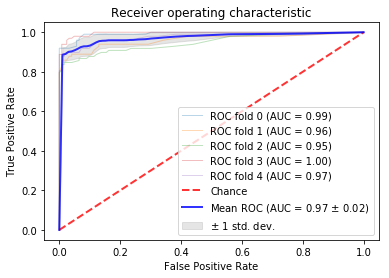

In [168]:
FiveFoldROC(rf, X_res, Y_res)

In [169]:
y_pred = rf.predict(X_res)
print('Classification Report for training')
print(classification_report(y_pred, Y_res))

Classification Report for training
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       628
           1       0.97      1.00      0.98       479

    accuracy                           0.99      1107
   macro avg       0.98      0.99      0.99      1107
weighted avg       0.99      0.99      0.99      1107



In [170]:
from sklearn.preprocessing import MinMaxScaler
evaluation = pd.read_csv('../Data/creditcard.csv')

X_eval = evaluation.drop(labels='Class', axis=1)
y_eval = evaluation.loc[:,'Class']

In [171]:
def Random_Forest_eval(estimator, X_test, y_test):
    
    y_pred = estimator.predict(X_test)

    print('Classification Report')
    print(classification_report(y_test, y_pred))
    y_score = estimator.predict_proba(X_test)[:,1]
    print('AUPRC', average_precision_score(y_test, y_score))
    print('AUROC', roc_auc_score(y_test, y_score))

In [172]:
Random_Forest_eval(rf, X_eval, y_eval)

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    284315
           1       0.09      0.97      0.16       492

    accuracy                           0.98    284807
   macro avg       0.54      0.98      0.57    284807
weighted avg       1.00      0.98      0.99    284807

AUPRC 0.7881914311173064
AUROC 0.9941632534565679
